# Homework 4 - K. V. V. Krishna Teja 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp
import pathos.multiprocessing as pmp # -pip install pathos (if not on machine)

print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.1.0


#### Import MNIST data

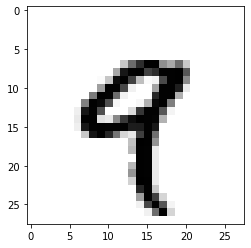

In [2]:
import gzip
import idx2numpy # - pip install idx2numpy (if not on machine)
from tqdm.auto import tqdm # - pip install tqdm (if not on machine)

trainimage = gzip.open('train-images-idx3-ubyte.gz','r')
trainarray = idx2numpy.convert_from_file(trainimage)
trainarray = trainarray.astype('float32') / 255.0
input_size = trainarray.shape[1] * trainarray.shape[2]
latent_size = 32
train_array = trainarray.reshape(trainarray.shape[0],input_size)

plt.imshow(trainarray[4], cmap=plt.cm.binary)
#trainarray.shape

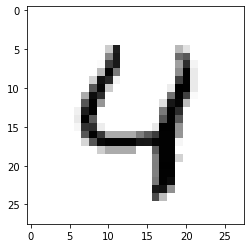

In [3]:
testimage = gzip.open('t10k-images-idx3-ubyte.gz','r')
testarray = idx2numpy.convert_from_file(testimage)
testarray = testarray.astype('float32') / 255.0
test_array = testarray.reshape(testarray.shape[0],input_size)

plt.imshow(testarray[4], cmap=plt.cm.binary)
#testarray.shape

### Autoencoder for 0.1 noise factor

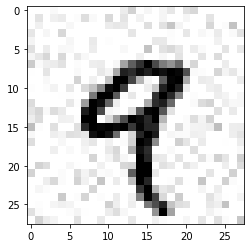

In [4]:
noise_factor = 0.1
x_noisy = trainarray + np.random.randn(*trainarray.shape) * noise_factor # adds random Gaussian noise scaled by a factor (noise_factor)
x_noisy = x_noisy.clip(0.0, 1.0) # clips image values to stay between 0.0 and 1.0
train_noisy = x_noisy.reshape(trainarray.shape[0],28,28,1)

plt.imshow(x_noisy[4], cmap=plt.cm.binary)

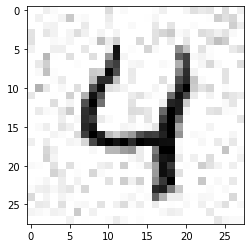

In [5]:
y_noisy = testarray + np.random.randn(*testarray.shape) * noise_factor # adds random Gaussian noise scaled by a factor (noise_factor)
y_noisy = y_noisy.clip(0.0, 1.0) # clips image values to stay between 0.0 and 1.0
test_noisy = y_noisy.reshape(testarray.shape[0],28,28,1)

plt.imshow(y_noisy[4], cmap=plt.cm.binary)

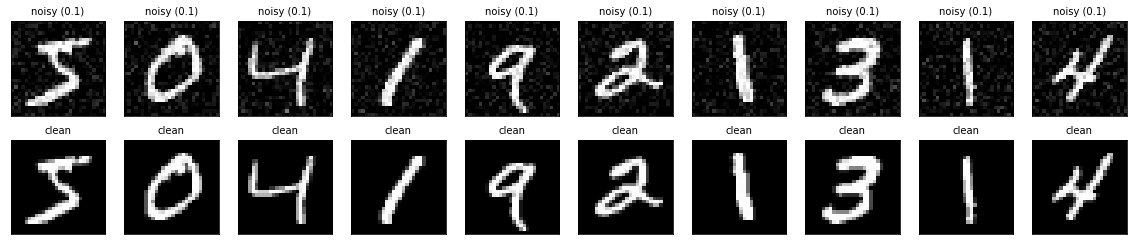

In [6]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_noisy[i].reshape(28, 28))
    plt.gray()
    ax.set_title('noisy (0.1)', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(trainarray[i].reshape(28, 28))
    plt.gray()
    ax.set_title('clean', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11131817234459911691
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6574135706
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11301681749347081018
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Reshape, Flatten, UpSampling2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ReLU, Activation, MaxPooling2D
from tensorflow.keras import backend as K

with tf.device('/GPU:0'): # Choose /CPU:0 or /GPU:0 depending on load...
    print('Auto-encoder experiment running on GPU...')
    # encoder
    enc_input = Input(shape=(input_size,)) 
    enc_dense = Dense(units=latent_size, activation="relu")(enc_input)
    enc_output = ReLU()(enc_dense)
    encoder = Model(enc_input, enc_output)
    #encoder.summary()
    # decoder
    dec_input = Input(shape=(latent_size,))
    dec_dense = Dense(units=input_size, activation="relu")(dec_input)
    dec_output = ReLU()(dec_dense)
    decoder = Model(dec_input, dec_output)
    #decoder.summary()
    #autoencoder
    aen_input = Input(shape=(input_size,))
    aen_enc_output = encoder(aen_input)
    aen_dec_output = decoder(aen_enc_output)
    aen = Model(aen_input, aen_dec_output)
    #aen.summary()
    custom_optm = tf.keras.optimizers.Adam(learning_rate=1e-3)
    aen.compile(loss='binary_crossentropy', optimizer=custom_optm, metrics=['accuracy'])
    history = aen.fit(train_array, train_array,
                    epochs=10,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(test_array, test_array))

Auto-encoder experiment running on GPU...
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.2883 - accuracy: 0.8004 - val_loss: 0.2292 - val_accuracy: 0.8033
Epoch 2/10
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2357 - accuracy: 0.8036 - val_loss: 0.2316 - val_accuracy: 0.8037
Epoch 3/10
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2214 - accuracy: 0.8061 - val_loss: 0.2183 - val_accuracy: 0.8056
Epoch 4/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.2195 - accuracy: 0.8062 - val_loss: 0.2230 - val_accuracy: 0.8045
Epoch 5/10
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2114 - accuracy: 0.8069 - val_loss: 0.1948 - val_accuracy: 0.8067
Epoch 6/10
60000/60000 [==============================] - 1s 20us/sample - loss: 0.2034 - accuracy: 0.8072 - val_loss: 0.2104 - val_accuracy: 0.8065
Epoch 7/10
600

In [9]:
aen.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
model (Model)                (None, 32)                25120     
_________________________________________________________________
model_1 (Model)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [10]:
from numpy import reshape
encoded_images = encoder.predict(test_array)
decoded_images = decoder.predict(encoded_images)
pred_images = reshape(decoded_images, newshape=(decoded_images.shape[0], 28, 28))
#print(pred_images.shape)

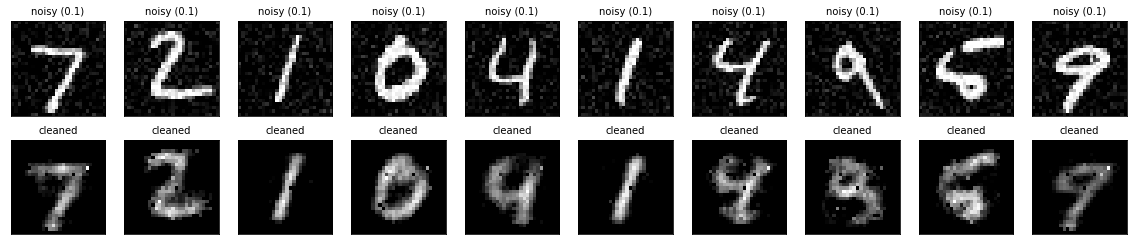

In [11]:
# Displaying and comparing predictions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.set_title('noisy (0.1)', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(pred_images[i].reshape(28, 28))
    plt.gray()
    ax.set_title('cleaned', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

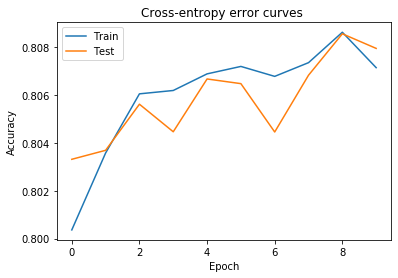

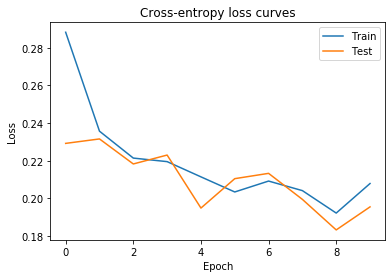

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Cross-entropy error curves ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cross-entropy loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Autoencoder for 0.5 noise factor

In [13]:
# Cleanup in progress...
del train_noisy
del test_noisy
del x_noisy
del y_noisy
del encoder
del decoder
del aen
del history
del encoded_images
del decoded_images
del pred_images
'Cleanup complete...'

'Cleanup complete...'

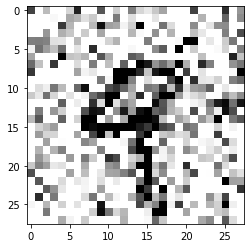

In [14]:
noise_factor = 0.5
x_noisy = trainarray + np.random.randn(*trainarray.shape) * noise_factor # adds random Gaussian noise scaled by a factor (noise_factor)
x_noisy = x_noisy.clip(0.0, 1.0) # clips image values to stay between 0.0 and 1.0
train_noisy = x_noisy.reshape(trainarray.shape[0],28,28,1)

plt.imshow(x_noisy[4], cmap=plt.cm.binary)

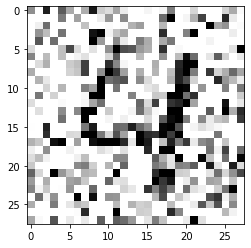

In [15]:
y_noisy = testarray + np.random.randn(*testarray.shape) * noise_factor # adds random Gaussian noise scaled by a factor (noise_factor)
y_noisy = y_noisy.clip(0.0, 1.0) # clips image values to stay between 0.0 and 1.0
test_noisy = y_noisy.reshape(testarray.shape[0],28,28,1)

plt.imshow(y_noisy[4], cmap=plt.cm.binary)

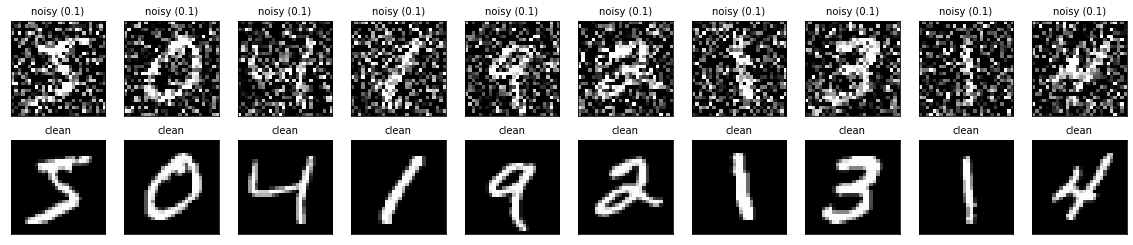

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_noisy[i].reshape(28, 28))
    plt.gray()
    ax.set_title('noisy (0.1)', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(trainarray[i].reshape(28, 28))
    plt.gray()
    ax.set_title('clean', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
with tf.device('/GPU:0'): # Choose /CPU:0 or /GPU:0 depending on load...
    print('Auto-encoder experiment running on GPU...')
    # encoder
    enc_input2 = Input(shape=(input_size,)) 
    enc_dense2 = Dense(units=latent_size, activation="relu")(enc_input2)
    enc_output2 = ReLU()(enc_dense2)
    encoder2 = Model(enc_input2, enc_output2)
    #encoder2.summary()
    # decoder
    dec_input2 = Input(shape=(latent_size,))
    dec_dense2 = Dense(units=input_size, activation="relu")(dec_input2)
    dec_output2 = ReLU()(dec_dense2)
    decoder2 = Model(dec_input2, dec_output2)
    #decoder2.summary()
    #autoencoder
    aen_input2 = Input(shape=(input_size,))
    aen_enc_output2 = encoder2(aen_input2)
    aen_dec_output2 = decoder2(aen_enc_output2)
    aen2 = Model(aen_input2, aen_dec_output2)
    #aen.summary()
    custom_optm = tf.keras.optimizers.Adam(learning_rate=1e-3)
    aen2.compile(loss='binary_crossentropy', optimizer=custom_optm, metrics=['accuracy'])
    history2 = aen2.fit(train_array, train_array,
                    epochs=10,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(test_array, test_array))

Auto-encoder experiment running on GPU...
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.3076 - accuracy: 0.8003 - val_loss: 0.2411 - val_accuracy: 0.8020
Epoch 2/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.2358 - accuracy: 0.8044 - val_loss: 0.2283 - val_accuracy: 0.8048
Epoch 3/10
60000/60000 [==============================] - 1s 19us/sample - loss: 0.2193 - accuracy: 0.8071 - val_loss: 0.2207 - val_accuracy: 0.8051
Epoch 4/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2218 - accuracy: 0.8068 - val_loss: 0.2310 - val_accuracy: 0.8062
Epoch 5/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2282 - accuracy: 0.8069 - val_loss: 0.2185 - val_accuracy: 0.8065
Epoch 6/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2198 - accuracy: 0.8077 - val_loss: 0.2027 - val_accuracy: 0.8083
Epoch 7/10
600

In [18]:
aen2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
model_3 (Model)              (None, 32)                25120     
_________________________________________________________________
model_4 (Model)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [19]:
from numpy import reshape
encoded_images2 = encoder2.predict(test_array)
decoded_images2 = decoder2.predict(encoded_images2)
pred_images2 = reshape(decoded_images2, newshape=(decoded_images2.shape[0], 28, 28))
#print(pred_images2.shape)

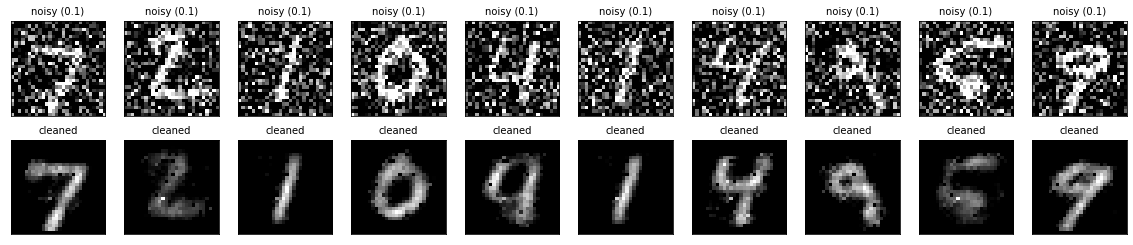

In [20]:
# Displaying and comparing predictions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.set_title('noisy (0.1)', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(pred_images2[i].reshape(28, 28))
    plt.gray()
    ax.set_title('cleaned', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

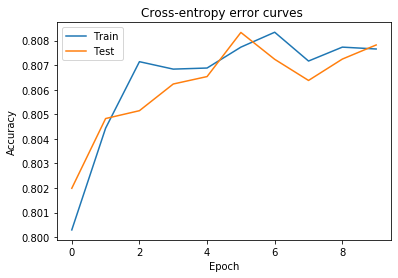

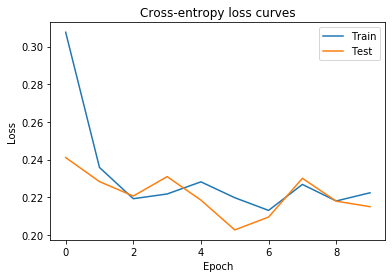

In [21]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Cross-entropy error curves ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Cross-entropy loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Autoencoder for 1.0 noise factor

In [22]:
# Cleanup in progress...
del train_noisy
del test_noisy
del x_noisy
del y_noisy
del encoder2
del decoder2
del aen2
del history2
del encoded_images2
del decoded_images2
del pred_images2
'Cleanup complete...'

'Cleanup complete...'

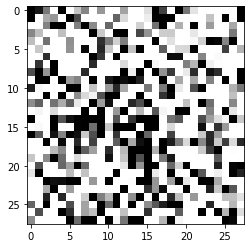

In [23]:
noise_factor = 1.0
x_noisy = trainarray + np.random.randn(*trainarray.shape) * noise_factor # adds random Gaussian noise scaled by a factor (noise_factor)
x_noisy = x_noisy.clip(0.0, 1.0) # clips image values to stay between 0.0 and 1.0
train_noisy = x_noisy.reshape(trainarray.shape[0],28,28,1)

plt.imshow(x_noisy[4], cmap=plt.cm.binary)

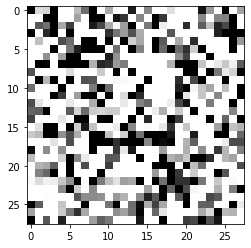

In [24]:
y_noisy = testarray + np.random.randn(*testarray.shape) * noise_factor # adds random Gaussian noise scaled by a factor (noise_factor)
y_noisy = y_noisy.clip(0.0, 1.0) # clips image values to stay between 0.0 and 1.0
test_noisy = y_noisy.reshape(testarray.shape[0],28,28,1)

plt.imshow(y_noisy[4], cmap=plt.cm.binary)

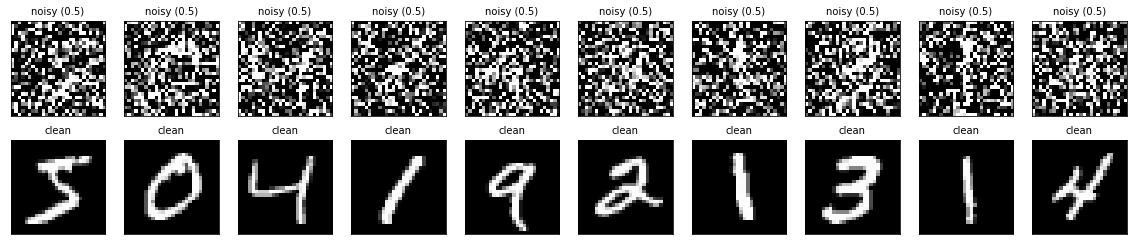

In [25]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_noisy[i].reshape(28, 28))
    plt.gray()
    ax.set_title('noisy (0.5)', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(trainarray[i].reshape(28, 28))
    plt.gray()
    ax.set_title('clean', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [26]:
with tf.device('/GPU:0'): # Choose /CPU:0 or /GPU:0 depending on load...
    print('Auto-encoder experiment running on GPU...')
    # encoder
    enc_input3 = Input(shape=(input_size,)) 
    enc_dense3 = Dense(units=latent_size, activation="relu")(enc_input3)
    enc_output3 = ReLU()(enc_dense3)
    encoder3 = Model(enc_input3, enc_output3)
    #encoder3.summary()
    # decoder
    dec_input3 = Input(shape=(latent_size,))
    dec_dense3 = Dense(units=input_size, activation="relu")(dec_input3)
    dec_output3 = ReLU()(dec_dense3)
    decoder3 = Model(dec_input3, dec_output3)
    #decoder3.summary()
    #autoencoder
    aen_input3 = Input(shape=(input_size,))
    aen_enc_output3 = encoder3(aen_input3)
    aen_dec_output3 = decoder3(aen_enc_output3)
    aen3 = Model(aen_input3, aen_dec_output3)
    #aen3.summary()
    custom_optm = tf.keras.optimizers.Adam(learning_rate=1e-3)
    aen3.compile(loss='binary_crossentropy', optimizer=custom_optm, metrics=['accuracy'])
    history3 = aen3.fit(train_array, train_array,
                    epochs=10,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(test_array, test_array))

Auto-encoder experiment running on GPU...
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 24us/sample - loss: 0.2984 - accuracy: 0.8007 - val_loss: 0.2330 - val_accuracy: 0.8037
Epoch 2/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2382 - accuracy: 0.8031 - val_loss: 0.2143 - val_accuracy: 0.8036
Epoch 3/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2124 - accuracy: 0.8049 - val_loss: 0.2055 - val_accuracy: 0.8041
Epoch 4/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2135 - accuracy: 0.8048 - val_loss: 0.2046 - val_accuracy: 0.8027
Epoch 5/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.1965 - accuracy: 0.8062 - val_loss: 0.1875 - val_accuracy: 0.8065
Epoch 6/10
60000/60000 [==============================] - 1s 18us/sample - loss: 0.1862 - accuracy: 0.8078 - val_loss: 0.1747 - val_accuracy: 0.8076
Epoch 7/10
600

In [27]:
aen3.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
model_6 (Model)              (None, 32)                25120     
_________________________________________________________________
model_7 (Model)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [28]:
from numpy import reshape
encoded_images3 = encoder3.predict(test_array)
decoded_images3 = decoder3.predict(encoded_images3)
pred_images3 = reshape(decoded_images3, newshape=(decoded_images3.shape[0], 28, 28))
#print(pred_images3.shape)

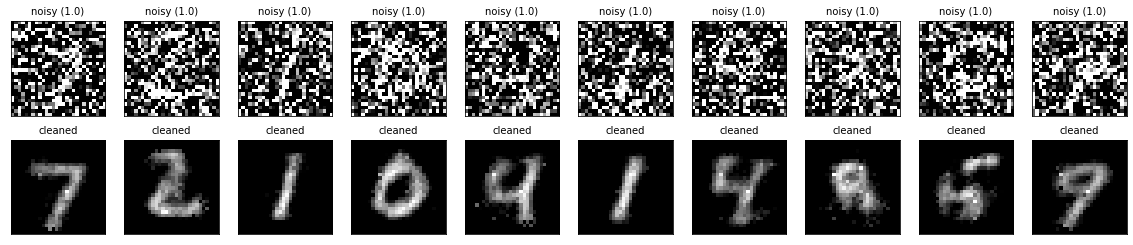

In [29]:
# Displaying and comparing predictions
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.set_title('noisy (1.0)', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(pred_images3[i].reshape(28, 28))
    plt.gray()
    ax.set_title('cleaned', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

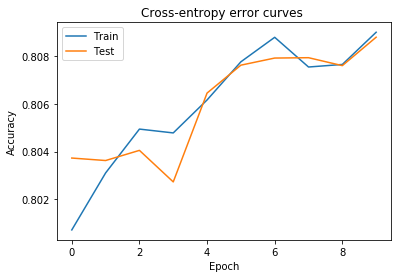

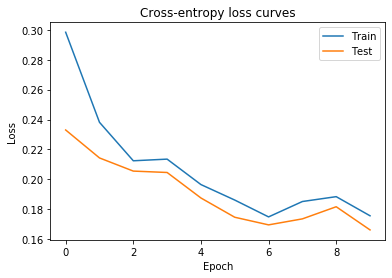

In [30]:
# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Cross-entropy error curves ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Cross-entropy loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Comments

As we notice in these three models, this simple autoencoder model does perform decently in denoising the images. But we can also see that for some images, their recontruction leads to a lossy image and the end result is less than desirable. 

How can this be overcome?

I believe this can be overcome by increasing the depth of the model by allowing more layers to allow less vanishing gradients.

# Cleanup in progress...
#del train_noisy
#del test_noisy
#del x_noisy
#del y_noisy
del encoder3
del decoder3
del aen3
del history3
del encoded_images3
del decoded_images3
del pred_images3
'Cleanup complete...'

In [31]:
del train_array
del test_array
train_array = trainarray.reshape(trainarray.shape[0],28,28,1)
test_array = testarray.reshape(testarray.shape[0],28,28,1)

In [32]:
with tf.device('/GPU:0'): # Choose /CPU:0 or /GPU:0 depending on load...
    print('Auto-encoder experiment running on GPU...')
    model4 = Sequential()
    # encoder
    model4.add(Conv2D(1, (7, 7), activation='relu', padding='same', input_shape=(28,28,1))) #28 x 28 x 1
    model4.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model4.add(Conv2D(4, (7, 7), activation='relu', padding='same')) #14 x 14 x 4
    model4.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model4.add(Conv2D(16, (7, 7), activation='relu', padding='same')) #7 x 7 x 16
    # decoder
    model4.add(Conv2D(16, (7, 7), activation='relu', padding='same')) #7 x 7 x 16
    model4.add(UpSampling2D((2, 2)))
    model4.add(Conv2D(4, (7, 7), activation='relu', padding='same')) #14 x 14 x 4
    model4.add(UpSampling2D((2, 2)))
    model4.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same')) #28 x 28 x 1
    
    custom_optm = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model4.compile(loss='binary_crossentropy', optimizer=custom_optm, metrics=['accuracy'])
    
    history4 = model4.fit(train_noisy, train_array,
                    epochs=10,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(test_noisy, test_array))

Auto-encoder experiment running on GPU...
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2415 - accuracy: 0.7982 - val_loss: 0.1970 - val_accuracy: 0.7937
Epoch 2/10
60000/60000 [==============================] - 2s 32us/sample - loss: 0.1870 - accuracy: 0.7979 - val_loss: 0.1779 - val_accuracy: 0.7995
Epoch 3/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1776 - accuracy: 0.7998 - val_loss: 0.1728 - val_accuracy: 0.8009
Epoch 4/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1736 - accuracy: 0.8007 - val_loss: 0.1700 - val_accuracy: 0.7997
Epoch 5/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1709 - accuracy: 0.8013 - val_loss: 0.1678 - val_accuracy: 0.8018
Epoch 6/10
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1687 - accuracy: 0.8019 - val_loss: 0.1657 - val_accuracy: 0.8024
Epoch 7/10
600

In [33]:
pred4 = model4.predict(test_noisy)
pred4.shape

(10000, 28, 28, 1)

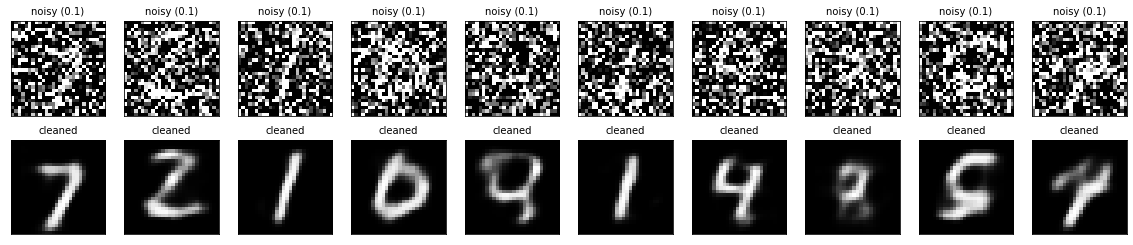

In [34]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.set_title('noisy (0.1)', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(pred4[i].reshape(28, 28))
    plt.gray()
    ax.set_title('cleaned', fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

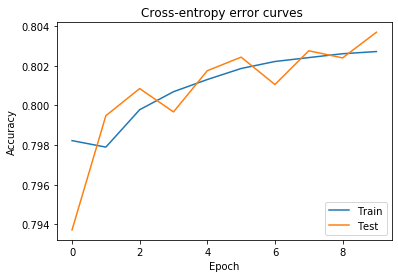

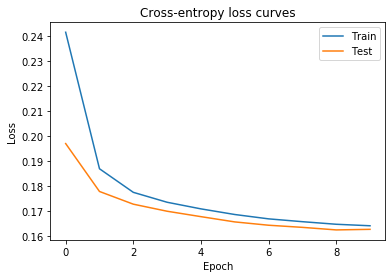

In [35]:
# Plot training & validation accuracy values
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Cross-entropy error curves ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Cross-entropy loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

As seen in this architecture, adding some depth via downsampling and upsampling leads to better resolution and clarity in the predictions.